In [1]:
# Import all necessary
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
import re
import requests

from sklearn.metrics import confusion_matrix,  multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.layers import BatchNormalization, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint


In [3]:
# Lists to store images data and labels
X = []
Y = []

# Input shape for ANN and also to resize images 
input_shape = (96, 96, 3)

# Merge train and test data into one dataset
# Loop through train and test subsets

path_to_subset = f'dataset/'

# Loop through all classes in subset
for folder in os.listdir(path_to_subset):

    # Loop through all images in each class
    for image in os.listdir(os.path.join(path_to_subset, folder)):
        # Defining path to image
        path_to_image = os.path.join(path_to_subset, folder, image)
        # Reading image using cv2
        image = cv.imread(path_to_image)
        # Resizing image
        image = cv.resize(image, (input_shape[1], input_shape[0]))
        # Extracting labels from 'path_to_image' using regex
        label = re.findall(r'\w+\_\w+', path_to_image)[0].split('_')

        # Appending data and labels to X and Y lists
        X.append(image)
        Y.append(label)

# Convert X to numpy array and scale values between 0 and 1
X = np.array(X) / 255.0
Y = np.array(Y)

# Binarize labels
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(Y)

In [4]:
# mlb classes and example of binarized label
print(mlb.classes_)
print(Y[0])

['black' 'blue' 'brown' 'dress' 'green' 'pants' 'red' 'shirt' 'shoes'
 'shorts' 'white']
[0 0 0 0 1 0 0 1 0 0 0]


In [5]:
# test_x and test_y will be used for final predictions
x, test_x, y, test_y = train_test_split(X, Y, 
                                        test_size = 0.1, 
                                        stratify = Y, 
                                        shuffle = True, 
                                        random_state = 1)
# train_x, val_x, train_y, val_y will be used to train model and validate results during training
train_x, val_x, train_y, val_y = train_test_split(x, y, 
                                                  test_size = 0.2, 
                                                  stratify = y, 
                                                  shuffle = True, 
                                                  random_state = 1)

print(x.shape, test_x.shape, y.shape, test_y.shape)
print(train_x.shape, val_x.shape, train_y.shape, val_y.shape)

# I'll use ImageDataGenerator to apply random transformations to images
datagen = ImageDataGenerator(rotation_range = 45,
                            width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            validation_split = 0.2)

(10246, 96, 96, 3) (1139, 96, 96, 3) (10246, 11) (1139, 11)
(8196, 96, 96, 3) (2050, 96, 96, 3) (8196, 11) (2050, 11)


In [6]:
# Creating model architecture
model = Sequential()

model.add(Conv2D(32, 3, padding = 'same', input_shape = input_shape, kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, 2, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# model.summary()

# use a *softmax* activation for single-label classification
# and *sigmoid* activation for multi-label classification
model.add(Dense(len(mlb.classes_), activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        3

In [ ]:
# Checkpoint to save best model
checkpoint = ModelCheckpoint('best_model.hdf5', save_best_only = True, monitor = 'val_loss', verbose = 1)
history = model.fit(datagen.flow(train_x, train_y, 
                    batch_size = 64),
                    validation_data = (val_x, val_y), 
                    epochs = 1, 
                    verbose = 1, 
                    callbacks = [checkpoint])
#                     class_weight = weights)


 32/129 [======>.......................] - ETA: 3:41 - loss: 0.2121 - accuracy: 0.5708

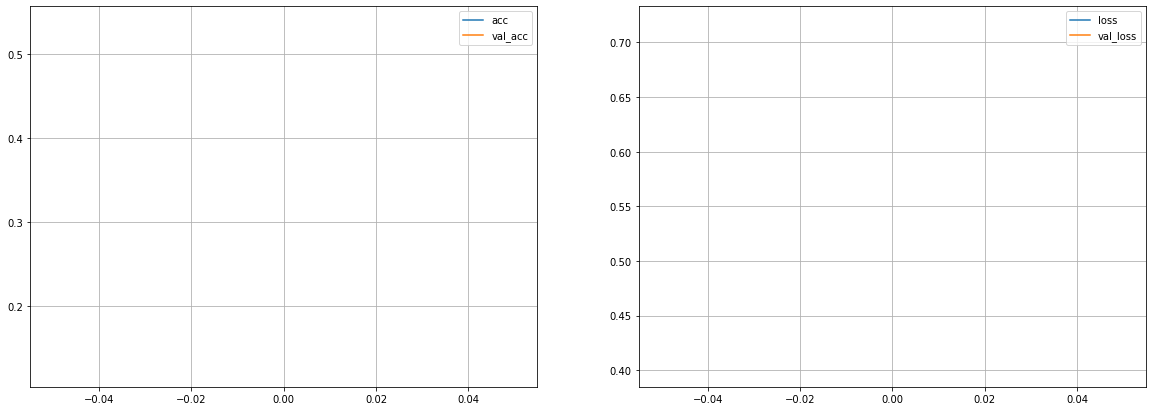

In [8]:
# Plot training results
H = history.history
fig = plt.figure(figsize = (20, 7))
plt.subplot(121)
plt.plot(H['accuracy'], label = 'acc')
plt.plot(H['val_accuracy'], label = 'val_acc')
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(H['loss'], label = 'loss')
plt.plot(H['val_loss'], label = 'val_loss')
plt.grid()
plt.legend()

<ipython-input-9-10fddd52043a>:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(f'23{i+1}')


IndexError: GridSpec slice would result in no space allocated for subplot

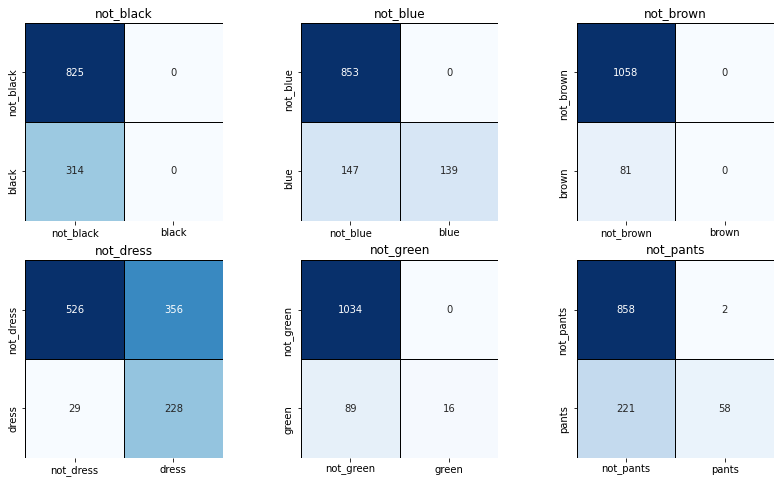

In [9]:
# Loading best weights
model.load_weights('best_model.hdf5')
# Save model for later usage
model.save('model.hdf5')

# Predicting test images
preds = model.predict(test_x)
preds = np.where(preds < 0.5, 0, 1)

# Creating multilabel confusion matrix
confusion = multilabel_confusion_matrix(test_y, preds)

# Plot confusion matrix 
fig = plt.figure(figsize = (14, 8))
for i, (label, matrix) in enumerate(zip(mlb.classes_, confusion)):
    plt.subplot(f'23{i+1}')
    labels = [f'not_{label}', label]
    sns.heatmap(matrix, annot = True, square = True, fmt = 'd', cbar = False, cmap = 'Blues', 
                xticklabels = labels, yticklabels = labels, linecolor = 'black', linewidth = 1)
    plt.title(labels[0])

plt.tight_layout()
plt.show()

## Predicting Random Images

<ipython-input-10-92278a37c81d>:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(f'33{i+1}')


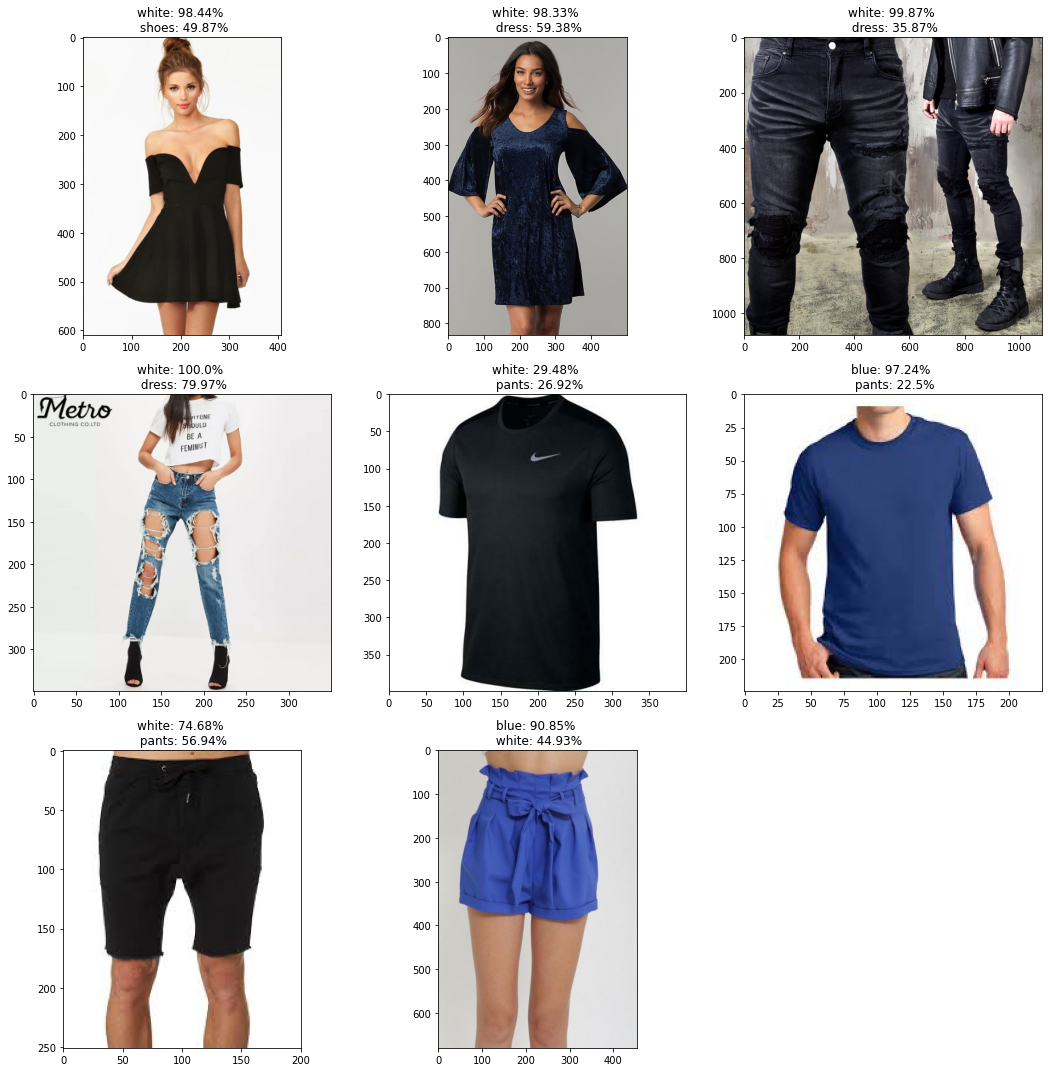

In [10]:
# URLs to images
urls = [
    'http://picture-cdn.wheretoget.it/e07ql5-l-610x610-dress-little+black+dress-skater+dress-nastygal-deep+vneck-short-formal-short+formal+dress-prom-short+prom+dress-black-lbd-short+black+dress-prom+dress-black+dress-blackdress-short+.jpg',
    'https://img.simplydresses.com/_img/SDPRODUCTS/2103981/500/navy-dress-JU-TI-T0468-a.jpg',
    'https://d2euz5hho4dp59.cloudfront.net/images/detailed/40/main_jean_419.jpg',
    'https://sc02.alicdn.com/kf/HTB1QbZ_dzgy_uJjSZJnq6zuOXXaq/Wholesale-scratch-pants-damaged-denim-women-s.jpg_350x350.jpg',
    'https://i.ebayimg.com/00/s/NjAwWDYwMA==/z/pakAAOSwVtta6SN8/$_1.JPG?set_id=880000500F',
    'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSFA1Q-O44dQWt1lvsnOQyoMcQ3myaxY-GscMHgmPtmyWT14ZJU',
    'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTJYyBOAy35RM7m0JzNGHo_-VTSf6bPMh9hACbhhqxsdoMXHQvD',
    'https://cdn.shopify.com/s/files/1/1359/6121/products/7481209_LF0A0919_1024x1024.jpg?v=1511982241',     
]

fig = plt.figure(figsize = (15, 15))

for i, url in enumerate(urls):
    plt.subplot(f'33{i+1}')
    
    # Sending request to the URL
    r = requests.get(url, stream = True).raw
    
    # Reading image, convert it to np array and decode
    image = np.asarray(bytearray(r.read()), dtype="uint8")
    image = cv.imdecode(image, cv.IMREAD_COLOR)
    # Resize, scale and reshape image before making predictions
    resized = cv.resize(image, (input_shape[1], input_shape[0]))
    resized = (resized / 255.0).reshape(-1, input_shape[1], input_shape[0], input_shape[2])
    
    # Predict results
    preds = model.predict(resized)
    preds = zip(list(mlb.classes_), list(preds[0]))
    preds = sorted(list(preds), key = lambda z: z[1], reverse = True)[:2]
    
    # Showing image
    plt.imshow(image[:, :, ::-1])
    plt.title(f'{preds[0][0]}: {round(preds[0][1] * 100, 2)}% \n {preds[1][0]}: {round(preds[1][1] * 100, 2)}%')    
        
plt.tight_layout()  